In [181]:
# styling
from IPython import utils  
from IPython.core.display import HTML  
import os  
def css_styling():  
    """Load default custom.css file from ipython profile"""
    base = utils.path.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open(os.path.join(base,'profile_default/static/custom/custom.css'),'r').read())
    return HTML(styles)
css_styling()  

In [182]:
%matplotlib inline

In [222]:
# libraries + pandas options
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import discrete
import re
import regex
import collections
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns
import json

pd.set_option('display.width', 1500)
pd.set_option('max_colwidth',100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.options.display.float_format = '{:,.3f}'.format
sns.set_style("whitegrid")
sns.set_context("poster")

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker
    

In [184]:
# EventRegistry login
from eventregistry import *
er = EventRegistry()
er.login("rradovanovic@college.harvard.edu","ruski.EVENT1")

Event Registry host: http://eventregistry.org


{u'action': u'success', u'desc': u'Login successful'}

# Notebook Contents

[Selecting Firms](#firms)

[Obtaining Firms Data & Financials](#financials)

[Get company concepts](#concepts)
  * [Get list of company names](#comnam)
  * [Testing getConceptUri](#getconcept)      
  * [Ticker-name dictionary](#namesdict)
  * [Testing suggestConcepts](#suggestconcepts)
  * [Exploring concept info](#conceptinfo)
  * [Ticker-uri dictionary](#ticdict)

[Querying News](#news)
  * [Exploring classifications](#classifications)
  * [Articles](#articles)
  * [Events](#events)

# Selecting Firms <a id='firms'></a>

Similar to Yaros & Imielinski(Y&I, 2015), in this paper I use firms from the S&P 500, 400, and 600. To obtain the constituents of these indexes I follow the instructions in xxxxxpaper. I query COMPUSTAT's monthly index constituents database for the time range 2014-2016, as this is the period for which Event Registry has news data. It should be noted that this query results in  significantly more firms that 1500, due to the fact that there is turnover in the membership of each of the indexes. In various studies, this, as well as survivorship bias, can be of concern. However, in this study, I will specifically be comparing the performance of two different methods on the same dataset. I see no reason to believe one method would be more or less effective than the other due to these reasons. As such, neither of these concerns should bias my results.   

I obtain the list loaded below:

In [73]:
# load list
indexfirmdf = pd.read_csv('../data/firms/sp500_400_600.csv')
indexfirmdf.head()

,gvkey,iid,gvkeyx,from,thru,conm,tic,spii,spmi,co_conm,co_tic,co_cusip,co_cik,co_sic,co_naics
0,1078,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,ABBOTT LABORATORIES,ABT,2824100,"1,800.000","2,834.000","325,412.000"
1,1300,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,HONEYWELL INTERNATIONAL INC,HON,438516106,"773,840.000","3,822.000","334,512.000"
2,1356,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,ALCOA INC,AA,13817101,"4,281.000","3,350.000","3,313.000"
3,1440,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,AMERICAN ELECTRIC POWER CO,AEP,25537101,"4,904.000","4,911.000","2,211.000"
4,1976,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,BAKER HUGHES INC,BHI,57224107,"808,362.000","1,381.000","213,111.000"


Below, we take a look at the number of firms returned for each index over the period. As we might expect, the least turnover occurs within the S&P 500 index. 

In [6]:
# index summaries
indexcounts = pd.DataFrame(indexfirmdf.conm.value_counts()).reset_index()
indexcounts["target_number"] = [600, 500, 400] 
indexcounts.columns = ["index", "total_firms", "target_value_at_any_point"]
indexcounts["index composition turnover"] = (indexcounts.total_firms - indexcounts.target_value_at_any_point) / indexcounts.target_value_at_any_point  
indexcounts 

,index,total_firms,target_value_at_any_point,index composition turnover
0,S&P Smallcap 600 Index,737,600,0.228
1,S&P 500 Comp-Ltd,551,500,0.102
2,S&P Midcap 400 Index,505,400,0.263


# Obtaining Firm Data & Financials <a id=financials></a>

I obtain daily financial data on firm's stocks by using the CRSP database. I simply extract all tickers from the dataset above and upload them to WRDS. As noted, I query for data only from 2010 to today. 

In [7]:
# export ticks for words
np.savetxt('../data/firms/firmtics_500_400_600.txt',indexfirmdf.co_tic.values,  fmt='%s')

In [8]:
# load CRSP export
# choose which varibles to load
vars_to_load = [u'PERMNO', u'date', u'NAMEENDT', u'SHRCD', u'EXCHCD', u'SICCD', 
                u'NCUSIP', u'TICKER', u'COMNAM', u'SHRCLS', u'TSYMBOL', 
                u'NAICS', u'PRC', u'VOL', u'RET', u'RETX', 'sprtrn', u'NUMTRD']
financialdf = pd.read_csv("../data/financial data/crsp_400_600_500_2010_2015_all_var.csv", usecols = vars_to_load)


C:\Users\nolefp\AppData\Roaming\Python\Python27\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (5,6,9,48,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# clean up first load

# make everything lowercase
financialdf.columns = [x.lower() for x in financialdf.columns]

# convert date
financialdf.date = pd.to_datetime(financialdf.date, format="%Y/%m/%d", unit='D')

One possible concern for calculating correlations is that different stocks might have been listed or de-listed in different periods. It is important that the stocks we look at are present throughout the entire period. 

Full range of dates:  2010-01-04  to  2015-12-31
Total number of business days in range:  1563
Unique dates in dataset:  1510    *this number being less than the total business days is likely due to holidays
# Firms appearing on all dates in dataset:  1358


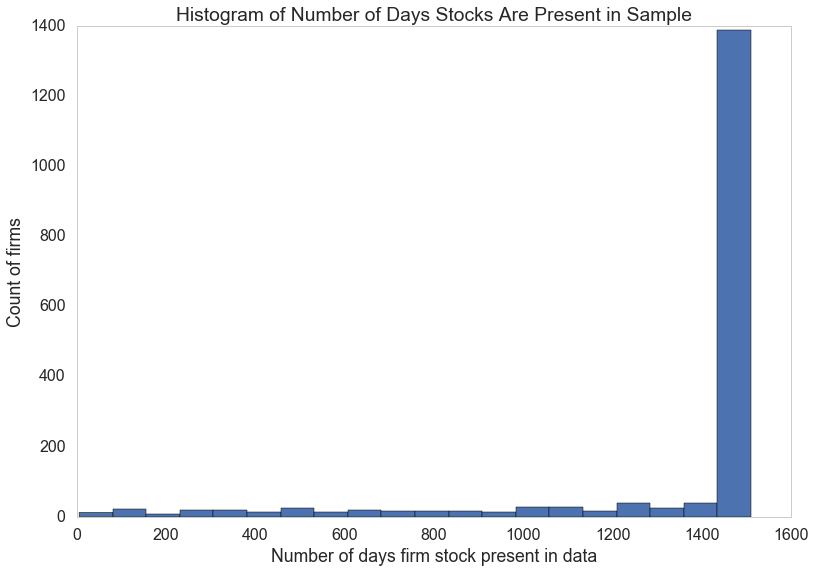

In [11]:
# check that all stocks are present on all dates in the dataset
plt.grid()
plt.title("Histogram of Number of Days Stocks Are Present in Sample")
plt.xlabel("Number of days firm stock present in data")
plt.ylabel("Count of firms")
plt.hist(financialdf.groupby("ticker").date.nunique(), bins=20);

print "Full range of dates: ", financialdf.date.min().date(), " to ", financialdf.date.max().date()
print "Total number of business days in range: ", np.busday_count(financialdf.date.min().date(), financialdf.date.max().date())
print "Unique dates in dataset: ", financialdf.date.nunique(), "   *this number being less than the total business days is likely due to holidays"
print "# Firms appearing on all dates in dataset: ", financialdf.groupby("ticker").date.nunique()[financialdf.groupby("ticker").date.nunique().values == 1510].count()

We drop stocks that are not present for the total number of trading days.

In [220]:
# drop stocks with gaps
totaldays = financialdf.date.nunique()
financialdf = financialdf.groupby("ticker").filter(lambda x: x.date.nunique() >= totaldays)
print "# of remaining stocks: ", financialdf.ticker.nunique()

# of remaining stocks:  1358


# Get company concepts <a id=concepts></a>

The goal here is to have a mapping between company stock tickers and all likely associated concept uri-s. The strategy is as follows:
1. Get a list of company names from CRSP
2. Create a dictionary mapping tickers and sets of possible company names
3. Query EventRegistry for top Uri matches given the names in those sets
4. End up with a dictionary mapping tickers to sets of associated Concept Uri-s

## Get list of company names <a id=comnam></a>

We use the COMNAM variable from CRSP to get company names. However, this isn't totally straightforward as it seems some companies changed their names throughout time or just happened to have different ticker-name pairs.

In [29]:
# check ticker - name pairs
print "Total Unique Tickers: ", financialdf.ticker.nunique()
print "Total Unique Names: ", financialdf.comnam.nunique()

Total Unique Tickers:  1358
Total Unique Names:  1458


Let's check which tickers have multiple names and what those names are:

In [74]:
# get list of tickers with duplicate names
diffnames = financialdf.groupby('ticker').comnam.unique()
pd.DataFrame(diffnames[diffnames.apply(lambda x: len(x) > 1)]).head(30)

,comnam
ticker,
ACM,"[A E C O M TECHNOLOGY CORP, A E C O M]"
ADC,"[ASTRO DRILLING CO, AGREE REALTY CORP]"
ALEX,"[ALEXANDER & BALDWIN INC, ALEXANDER & BALDWIN HLDGS INC, ALEXANDER & BALDWIN INC NEW]"
AMT,"[AMERICAN TOWER CORP, AMERICAN TOWER CORP NEW]"
AON,"[AON CORP, AON PLC]"
APOL,"[APOLLO GROUP INC, APOLLO EDUCATION GROUP INC]"
ARRS,"[ARRIS GROUP INC, ARRIS GROUP INC NEW]"
BIIB,"[BIOGEN IDEC INC, BIOGEN INC]"
CBG,"[C B RICHARD ELLIS GROUP INC, C B R E GROUP INC]"


OK, a visual inspection indicates that these tend to be small changes in phrasing. Nevertheless, we can take advantage of these and use all names in the set to query for uri-s. This is the approach we will take below. 

## Testing getConceptUri <a id=getconcept></a>

Concept uri-s are how EventRegistry tags individual concepts and recognizes them across articles. Interestingly, they are wikipedia links, and as such also have crowdsourced hierarchical information attached. 

EventRegistry offers two functions to obtain concept uri-s. The first is "getConceptUri" which only returns the top link. We play around a bit to get a sense of how this works:

In [80]:
# coca-cola queries
colaq = []
queries = ['COCA COLA ENTERPRISES INC',  
           'COCA COLA ENTERPRISES',
           'COCA COLA INC',
           'COCA COLA']
for query in queries:
    colaq.append([query, er.getConceptUri(query)])
colaq = pd.DataFrame(colaq, columns = ["Query", "Resulting Uri"]).set_index("Query")
colaq

,Resulting Uri
Query,
COCA COLA ENTERPRISES INC,None
COCA COLA ENTERPRISES,http://en.wikipedia.org/wiki/Coca-Cola_Enterprises
COCA COLA INC,"http://en.wikipedia.org/wiki/Coca-Cola_Bottlers_Philippines,_Inc."
COCA COLA,http://en.wikipedia.org/wiki/Coca-Cola


In [75]:
# devry queries
q = []
queries = ['DEVRY INC DEL',
           'DEVRY INC',
           'DEVRY DEL',
           'DEVRY EDUCATION GROUP INC',
           'DEVRY EDUCATION GROUP',
           'DEVRY EDUCATION INC',
           'DEVRY EDUCATION',
           'DEVRY GROUP',
           'DEVRY']

for query in queries:
    q.append([query, er.getConceptUri(query)])
q = pd.DataFrame(q, columns = ["Query", "Resulting Uri"]).set_index("Query")
q

,Resulting Uri
Query,
DEVRY INC DEL,None
DEVRY INC,http://en.wikipedia.org/wiki/DeVry_Inc.
DEVRY DEL,None
DEVRY EDUCATION GROUP INC,None
DEVRY EDUCATION GROUP,http://en.wikipedia.org/wiki/DeVry_Education_Group
DEVRY EDUCATION INC,None
DEVRY EDUCATION,http://en.wikipedia.org/wiki/DeVry_Education_Group
DEVRY GROUP,http://en.wikipedia.org/wiki/DeVry_Education_Group
DEVRY,http://en.wikipedia.org/wiki/DeVry_University


In [64]:
# cvs queries
cvsq = []
queries = ['C V S CAREMARK CORP', 
           'C V S CAREMARK',
           'C V S CORP',
           'C V S HEALTH CORP',
           'C V S HEALTH',
           'C V S',
           'CVS']
for query in queries:
    cvsq.append([query, er.getConceptUri(query)])
cvsq = pd.DataFrame(cvsq, columns = ["Query", "Resulting Uri"]).set_index("Query")
cvsq

,Resulting Uri
Query,
C V S CAREMARK CORP,None
C V S CAREMARK,None
C V S CORP,None
C V S HEALTH CORP,None
C V S HEALTH,None
C V S,None
CVS,http://en.wikipedia.org/wiki/CVS_Pharmacy


In [85]:
# test more abbreviations
cvsq = []
queries = ['CVS CAREMARK CORP', 
           'CVS CAREMARK',
           'CVS CORP',
           'CVS HEALTH CORP',
           'CVS HEALTH',
           'E N S C O INTL LTD', 
           'E N S C O INTL', 
           'E N S C O PLC', 
           'E N S C O PLC NEW',
           'E N S C O',
           'ENSCO INTL LTD', 
           'ENSCO INTL', 
           'ENSCO PLC', 
           'ENSCO PLC NEW',
           'ENSCO',
           'C I G N A CORP', 
           'CIGNA CORP',
           'C I G N A', 
           'CIGNA',
           'C B RICHARD ELLIS GROUP INC', 
           'C B R E GROUP INC',
           'CB RICHARD ELLIS GROUP INC', 
           'CBRE GROUP INC',
           'C B RICHARD ELLIS GROUP', 
           'C B R E GROUP',
           'CB RICHARD ELLIS GROUP', 
           'CBRE GROUP',
           'C B RICHARD ELLIS', 
           'C B R E',
           'CB RICHARD ELLIS', 
           'CBRE']
           
for query in queries:
    cvsq.append([query, er.getConceptUri(query)])
cvsq = pd.DataFrame(cvsq, columns = ["Query", "Resulting Uri"]).set_index("Query")
cvsq

,Resulting Uri
Query,
CVS CAREMARK CORP,None
CVS CAREMARK,http://en.wikipedia.org/wiki/CVS_Caremark
CVS CORP,None
CVS HEALTH CORP,None
CVS HEALTH,None
E N S C O INTL LTD,None
E N S C O INTL,None
E N S C O PLC,None
E N S C O PLC NEW,None


In [84]:
# check if lower vs. upper caps make a difference
cvsq = []
queries = ['CVS CAREMARK CORP', 
           'CVS CAREMARK',
           'CVS CORP',
           'CVS HEALTH CORP',
           'CVS HEALTH',
           'E N S C O INTL LTD', 
           'E N S C O INTL', 
           'E N S C O PLC', 
           'E N S C O PLC NEW',
           'E N S C O',
           'ENSCO INTL LTD', 
           'ENSCO INTL', 
           'ENSCO PLC', 
           'ENSCO PLC NEW',
           'ENSCO',
           'C I G N A CORP', 
           'CIGNA CORP',
           'C I G N A', 
           'CIGNA']
           
for query in queries:
    query = query.lower()
    cvsq.append([query, er.getConceptUri(query)])
cvsq = pd.DataFrame(cvsq, columns = ["Query", "Resulting Uri"]).set_index("Query")
cvsq

,Resulting Uri
Query,
cvs caremark corp,None
cvs caremark,http://en.wikipedia.org/wiki/CVS_Caremark
cvs corp,None
cvs health corp,None
cvs health,None
e n s c o intl ltd,None
e n s c o intl,None
e n s c o plc,None
e n s c o plc new,None


It seems like two things would greatly increase the accuracy of the matches:
1. get rid of words like INC and CORP (I believe Y&I do this as well).
2. join acronyms together

It also seems not to matter whether terms are upper or lower cap.

## Ticker-name dictionary <a id=namesdict></a>

My approach for removing things like "inc", "corp", etc, will be to:
1. change all terms to lower cap
2. create a dictionary with tickers as keys and sets of company names as values
3. count the number of times individual terms appear in all the company names
4. manually screen through the top terms for anything that should probably actually be kept, select the rest for removal
5. add to each ticker's set of company names a version of the same names except with the selected terms removed

In [243]:
# create initialize ticker-name dictionary 

# change all terms to lower cap
namesdict = diffnames.to_dict()

# change arrays to lowercase sets
for ticker, names in namesdict.items():
    lowercase = set()
    for name in names:
        lowercase.add(name.lower())
    namesdict[ticker] = lowercase
    
#namesdict

In [244]:
# figure out which terms to exclude
from collections import Counter

# get a list of all terms
allwords = []
for ticker, names in namesdict.items():
    for name in names:
        allwords.extend(name.split())

Counter(allwords).most_common(25)

[('inc', 851),
 ('corp', 377),
 ('co', 110),
 ('new', 92),
 ('group', 78),
 ('&', 67),
 ('international', 50),
 ('c', 48),
 ('financial', 41),
 ('energy', 36),
 ('s', 35),
 ('holdings', 33),
 ('industries', 30),
 ('m', 29),
 ('a', 29),
 ('systems', 29),
 ('t', 27),
 ('e', 26),
 ('technologies', 25),
 ('ltd', 23),
 ('i', 23),
 ('bancorp', 22),
 ('p', 21),
 ('b', 21),
 ('n', 19)]

I remove the following terms: inc, corp, co, ltd, plc. We can explore later whether it might be judicious to remove more terms. 

In [245]:
# remove uneccesary terms
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(re.sub(r"\b((inc)|(corp)|(co)|(ltd)|(plc))\b","", name).strip())
    namesdict[ticker] = new_names

# also remove 'group', but separately, sometimes it helps
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(re.sub(r"\b(group)\b","", name).strip())
    namesdict[ticker] = new_names
    
# also remove 'new', but separately, sometimes it helps
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(re.sub(r"\b(new)\b","", name).strip())
    namesdict[ticker] = new_names

Next, I concatenate all abbreviations:

In [246]:
# join abbreviations
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(regex.sub(r"(?<=\b[a-z])[ ](?=[a-z]\b)","", name))
    namesdict[ticker] = new_names

Ok, cool, we are ready to rumble! Let's take a look at the final dictionary and our total count of requests (hopefully not more than 10,000!):

In [357]:
# take a peek
total = 0
for ticker, names in namesdict.items():
    total += len(names)

print "Total names to Query: ", total
{k: namesdict[k] for k in namesdict.keys()[:25]}

Total names to Query:  3426


{'ACET': {'aceto', 'aceto corp'},
 'CPB': {'campbell soup', 'campbell soup co'},
 'CPF': {'central pacific financial', 'central pacific financial corp'},
 'CPT': {'camden property trust'},
 'EOG': {'eog resources', 'eog resources inc'},
 'EXAR': {'exar', 'exar corp'},
 'EXLS': {'exlservice holdings', 'exlservice holdings inc'},
 'IDXX': {'i d e x x laboratories',
  'i d e x x laboratories inc',
  'idexx laboratories',
  'idexx laboratories inc'},
 'JBHT': {'hunt j b transport services',
  'hunt j b transport services inc',
  'hunt jb transport services',
  'hunt jb transport services inc'},
 'JWN': {'nordstrom', 'nordstrom inc'},
 'KLIC': {'kulicke & soffa inds', 'kulicke & soffa inds inc'},
 'KRC': {'kilroy realty', 'kilroy realty corp'},
 'LGND': {'ligand pharmaceuticals', 'ligand pharmaceuticals inc'},
 'LSTR': {'landstar system', 'landstar system inc'},
 'NDSN': {'nordson', 'nordson corp'},
 'PHM': {'pulte',
  'pulte  inc',
  'pulte group',
  'pulte group inc',
  'pulte homes',
  '

## Testing suggestConcepts <a id=suggestconcepts></a>

We now quickly explore the "suggestConcepts" function of EventRegistry. There is no reason for us to only query one article for each company, so let's see how we might most fruitfully query multiple, *relevant*, articles at once. First, let's query for coca-cola:

In [208]:
# get coca cola concepts
cc_concepts = er.suggestConcepts("coca cola")
cc_concepts

[{u'id': u'39131',
  u'label': {u'eng': u'Coca-Cola'},
  u'score': 103290,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola'},
 {u'id': u'95230',
  u'label': {u'eng': u'The Coca-Cola Company'},
  u'score': 11229,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/The_Coca-Cola_Company'},
 {u'id': u'357107',
  u'label': {u'eng': u'Coca-Cola 600'},
  u'score': 3821,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_600'},
 {u'id': u'174873',
  u'label': {u'eng': u'Coca-Cola Zero'},
  u'score': 2083,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_Zero'},
 {u'id': u'38274',
  u'label': {u'eng': u'Coca-Cola Amatil'},
  u'score': 1546,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_Amatil'},
 {u'id': u'186235',
  u'label': {u'eng': u'Coca-Cola Enterprises'},
  u'score': 1084,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_Enterprises'},
 {u'id': u'1660880',
  u'label': {u

The above results can be categorized as follows:
- companies related to or owned by coca-cola (useful, easy to extract)
- coca cola products (useful, hard to extract)
- random wikipedia articles about coca cola, which, if identified in the news, could bear economic significance (useful, hard to extract)
- random wikipedia articles about coca cola, which, if identified in the news, would be unlikely to bear economic significance (not useful, hard to exract)

The one useful and easy to extract category is "organizations" or companies... We will take advantage of this later... Let us explore one more large corporation, "General Mills":

In [209]:
# get GM concepts
gm_concepts = er.suggestConcepts("goldman sachs")
gm_concepts

[{u'id': u'20400',
  u'label': {u'eng': u'Goldman Sachs'},
  u'score': 162268,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs'},
 {u'id': u'234252',
  u'label': {u'eng': u'Goldman Sachs Capital Partners'},
  u'score': 209,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs_Capital_Partners'}]

Less total results, but similar categories of results. Lastly, let us explore a very different type of firm, a financial firm:

In [210]:
# get goldman sachs concepts
gs_concepts = er.suggestConcepts("goldman sachs")
gs_concepts

[{u'id': u'20400',
  u'label': {u'eng': u'Goldman Sachs'},
  u'score': 162268,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs'},
 {u'id': u'234252',
  u'label': {u'eng': u'Goldman Sachs Capital Partners'},
  u'score': 209,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs_Capital_Partners'}]

## Exploring concept info <a id=conceptinfo></a>

It seems evident that we are better off querying for multiple concepts using suggestconcepturi instead of just one. However, it also evident that we need a better way of finding which concepts should really matter. In order to do that, we explore conceptinfo tags next, to see what we might be able to use to our advantage.

Because they are large, well known, and yet very different firms, we explore Coca-Cola and Goldman Sachs:

In [211]:
# define what info we are interested in
conceptflags = ConceptInfoFlags(type = "concepts",lang = "eng",label = False,synonyms = False,image = False,
                 description = False,details = False,conceptClassMembership = True,
                 conceptClassMembershipFull = True,conceptFolderMembership = True,trendingScore = False,
                 trendingHistory = False,trendingSource = "news")

In [ ]:
# update goldman sachs info
for i, concept in enumerate(gs_concepts):
    concept.update(er.getConceptInfo(concept['uri'], returnInfo= ReturnInfo(conceptInfo = conceptflags))[concept['uri']])
gs_concepts

In [ ]:
# update coca cola info
for concept in cc_concepts:
    concept.update(er.getConceptInfo(concept['uri'], returnInfo= ReturnInfo(conceptInfo = conceptflags))[concept['uri']])
cc_concepts

It appears that the conceptClassMembership could be used to find concepts which are *products* of the companies we are querying. This would be pretty cool, as it could add to the reach of our co-occurence graph in a likely significant way. Let's see what we get with Apple:

In [ ]:
# checking out apple
i_concepts = er.suggestConcepts("apple")
i_concepts

for concept in i_concepts:
    concept.update(er.getConceptInfo(concept['uri'], returnInfo= ReturnInfo(conceptInfo = conceptflags))[concept['uri']])
i_concepts

OK, for now, it seems like just filter on type='org' is the most efficient and holistic way of getting relevant concepts. Let's move on and finally get these uri-s.   

## Ticker-uri dictionary <a id=ticdict></a>

Essentially, what I do here, is get all the uri-s that might apply to a ticker based on all the names we have made for it... Let's run a test before we waste 3000 requests...

In [251]:
%%time
# run test version, 5 tickers
uridict = {}
i=0

# we add the test to see what happens when no concepts are found
for ticker, nameset in ([("TEST", ["asdvboasdjhvbzh"])] + namesdict.items()):
    ticker_uris_dict = {}
    for name in nameset:
        concepts = er.suggestConcepts(name)
        for concept in concepts:
            if concept['uri'] not in ticker_uris_dict:
                ticker_uris_dict[concept['uri']] = concept
    uridict[ticker] = ticker_uris_dict
    
    i += 1
    if i == 4:
        break

Wall time: 48.6 s


In [252]:
uridict

{'NDSN': {u'http://en.wikipedia.org/wiki/Nordson_Corporation': {u'id': u'1307928',
   u'label': {u'eng': u'Nordson Corporation'},
   u'score': 285,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Nordson_Corporation'}},
 'PKY': {u'http://en.wikipedia.org/wiki/Parkway_Properties': {u'id': u'1669686',
   u'label': {u'eng': u'Parkway Properties'},
   u'score': 128,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Parkway_Properties'}},
 'RYN': {u'http://en.wikipedia.org/wiki/Rayonier': {u'id': u'105755',
   u'label': {u'eng': u'Rayonier'},
   u'score': 1156,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Rayonier'}},
 'TEST': {}}

OK. That looks like it is working. Entries that have no matches will simply have empty dictionaries, which is pretty easy to query for later, so let's do this, wahoo! 

In [253]:
%%time
uridict = {}
for ticker, nameset in namesdict.items():
    ticker_uris_dict = {}
    for name in nameset:
        concepts = er.suggestConcepts(name)
        for concept in concepts:
            if concept['uri'] not in ticker_uris_dict:
                ticker_uris_dict[concept['uri']] = concept
    uridict[ticker] = ticker_uris_dict

Wall time: 39min 42s


In [254]:
# we save the results as a json file to preserve the information structure
"""
with open('../data/uridict.json', 'w') as fp:
    json.dump(uridict, fp, indent=4)
""";

with open('../data/uridict.json', 'r') as fp:
    uridict = json.load(fp)


## Analyzing uri yields

In [302]:
# get some yield summarty stats
ticker_uri_counts = []
for ticker, uridicts in uridict.items():
    ticker_uri_counts.append([ticker, len(uridicts)])
uricounts = pd.DataFrame(ticker_uri_counts, columns=["Ticker","Uri Count"])
uricounts.set_index('Ticker', inplace=1)

print "Total number of tickers: ", len(uricounts.index)
print "Number of tickers with no uri: ", uricounts['Uri Count'].value_counts().loc[0,]
yield_ = 100 * (float(len(uricounts.index)) - uricounts['Uri Count'].value_counts().loc[0,]) / len(uricounts.index)
print "Rough Yield: {:,.2f}%".format(yield_)

Total number of tickers:  1358
Number of tickers with no uri:  459
Rough Yield: 66.20%


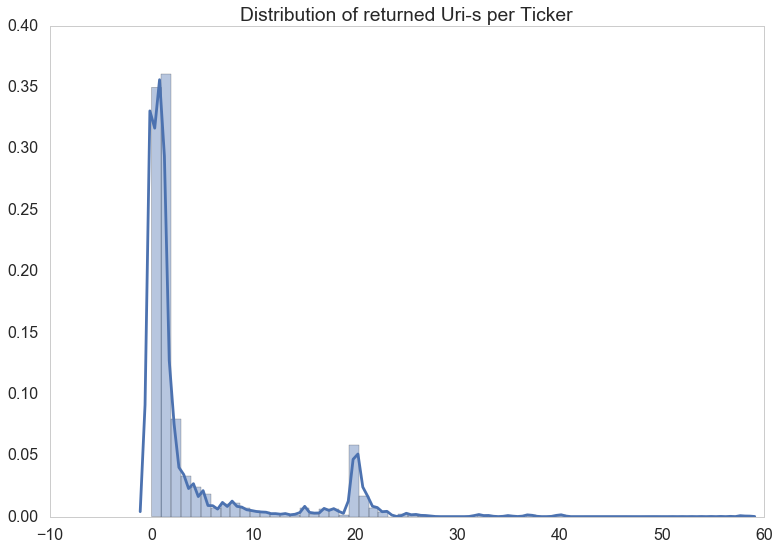

In [277]:
# plot hist
plt.grid()
plbt.title("Distribution of returned Uri-s per Ticker")
sns.distplot(uricounts, norm_hist=False, bins=60)

In [318]:
# show exact table of distribution
distribution = pd.DataFrame(uricounts['Uri Count'].value_counts())
distribution.reset_index(inplace=1)
distribution.columns = [["Number of uri-s assigned to Ticker", "Count of Tickers"]]
distribution.set_index("Number of uri-s assigned to Ticker",inplace=1)
distribution.head(10)

,Count of Tickers
Number of uri-s assigned to Ticker,
1,473
0,459
2,104
20,77
3,43
4,32
5,24
21,22
8,15


1. this is great! In the first pilot test that I did, my yield was about 38 associated tickers out of 300, so we have made this whole process about 6 times more effective, and raised the yield from about 10% to 66% by doing some simple company name cleaning.

2. The distribution makes sense. The default limit on return URI-s, which I left in place during this process, is 20 uri-s. As such, it makes sense that we would have a bimodal distribution. The only way you can have more than 20 results is if two different names yield different uri-s. 

3. Let's move on to examine this to some more detail:

In [355]:
%debug
# get industry classifications
sic = pd.read_csv('../data/financial/crsp_400_600_500_2010_2015_all_var.csv', usecols=["TICKER","HSICCD"])
sic = sic.drop_duplicates("TICKER")
sic["SIC2"] = pd.to_numeric(sic.HSICCD)
sic["SIC2"] = sic.SIC2.astype('str').str[:2]
sic["SIC2"]

SIC Classes:
010999	Agriculture, Forestry and Fishing
1000-1499	Mining
1500-1799	Construction
1800-1999	not used
2000-3999	Manufacturing
4000-4999	Transportation, Communications, Electric, Gas and Sanitary service
5000-5199	Wholesale Trade
5200-5999	Retail Trade
6000-6799	Finance, Insurance and Real Estate
7000-8999	Services
9100-9729	Public Administration
9900-9999	Nonclassifiable

> c:\users\nolefp\dropbox\senior year\information in financial markets\final paper\notebooks\pandas\src\inference.pyx(598)pandas.lib.maybe_convert_numeric (pandas\lib.c:53719)()

ipdb> 
ipdb> 
ipdb> next


ValueError: Unable to parse string

In [337]:
SIC = pd.read_csv("../data/financial/crsp_400_600_500_2010_2015_ticker_comnam_SIC2.csv")
uricounts["comnames"] = diffnames
uricounts



,Uri Count,comnames
Ticker,,
RYN,1,[RAYONIER INC NEW]
NDSN,1,[NORDSON CORP]
BMI,0,[BADGER METER INC]
EOG,1,[EOG RESOURCES INC]
LSTR,1,[LANDSTAR SYSTEM INC]
VSAT,18,[VIASAT INC]
CRS,1,[CARPENTER TECHNOLOGY CORP]
CPB,3,[CAMPBELL SOUP CO]
EXLS,0,[EXLSERVICE HOLDINGS INC]


# Querying News <a id=news></a>

## Exploring product classification capabilities <a id=classifications></a>

In [214]:
er.suggestCategories("business")

[{u'id': 19, u'label': u'Business', u'uri': u'dmoz/Business'},
 {u'id': 530,
  u'label': u'Business/Hospitality',
  u'uri': u'dmoz/Business/Hospitality'},
 {u'id': 496,
  u'label': u'Business/Automotive',
  u'uri': u'dmoz/Business/Automotive'},
 {u'id': 484,
  u'label': u'Business/Telecommunications',
  u'uri': u'dmoz/Business/Telecommunications'},
 {u'id': 352,
  u'label': u'Business/Publishing_and_Printing',
  u'uri': u'dmoz/Business/Publishing_and_Printing'},
 {u'id': 327,
  u'label': u'Business/Industrial_Goods_and_Services',
  u'uri': u'dmoz/Business/Industrial_Goods_and_Services'},
 {u'id': 447,
  u'label': u'Business/Healthcare',
  u'uri': u'dmoz/Business/Healthcare'},
 {u'id': 431,
  u'label': u'Business/Construction_and_Maintenance',
  u'uri': u'dmoz/Business/Construction_and_Maintenance'},
 {u'id': 382,
  u'label': u'Business/Aerospace_and_Defense',
  u'uri': u'dmoz/Business/Aerospace_and_Defense'},
 {u'id': 365,
  u'label': u'Business/Retail_Trade',
  u'uri': u'dmoz/Business

## Articles <a id=articles></a>

In [ ]:
"""
%%time

# get all articles

q_dict_art = {}
res_dict_art = {}

for i in range(len(uridf)):
    # get concept and uri
    concept = uridf.index[i]
    uri = uridf.uri[i]
    
    # create article query
    q_dict_art[uri] = QueryArticles()
    q_dict_art[uri].addConcept(uri)
    q_dict_art[uri].addRequestedResult(RequestArticlesUriList(count=50000))
    
    # store results
    res_dict_art[uri] = er.execQuery(q_dict[uri])
""";

In [ ]:
# save so no more requesting
#with open('../data/res_dict_art.json', 'w') as fp:
#    json.dump(res_dict_art, fp, indent=4)

with open('../data/res_dict_art.json', 'r') as fp:
    res_dict_art = json.load(fp)

In [ ]:
# get dict of concepts and articles
conartdict = {}

for uri, res in res_dict_art.items():
    if 'uriList' in res_dict_art[uri]:
        if 'results' in res_dict_art[uri]['uriList']:
            conartdict[uri] = set(res_dict_art[uri]['uriList']['results'])
        else:
            conartdict[uri] = set()
    else:
        conartdict[uri] = set()

In [ ]:
# check totals
for uri, articles in conartdict.items():
    print uri, len(articles)

In [ ]:
# check rough concept matrix
artcovdf = pd.DataFrame(index=uridf.index.unique(), columns=uridf.index.unique())

for i in uridf.index.unique():
    for j in uridf.index.unique():
        uri_i = uridf.loc[i,:].uri
        uri_j = uridf.loc[j,:].uri
        artcovdf.loc[i, j] = len(conartdict[uri_i].intersection(conartdict[uri_j])) / len(conartdict[uri_i].union(conartdict[uri_j]))

## Events <a id=events></a>

In [ ]:
"""
%%time

# get all events

q_dict_evt = {}
res_dict_evt = {}

for i in range(len(uridf)):
    # get concept and uri
    concept = uridf.index[i]
    uri = uridf.uri[i]
    
    # create article query
    q_dict_evt[uri] = QueryEvents()
    q_dict_evt[uri].addConcept(uri)
    q_dict_evt[uri].addRequestedResult(RequestEventsUriList(count=50000))
    
    # store results
    res_dict_evt[uri] = er.execQuery(q_dict_evt[uri])
""";

In [ ]:
#with open('../data/res_dict_evt.json', 'w') as fp:
#    json.dump(res_dict_evt, fp, indent=4)

with open('../data/res_dict_evt.json', 'r') as fp:
    res_dict_evt = json.load(fp)

In [ ]:
# get dictionary of concepts and article tags
conevtdict = {}

for uri, res in res_dict_evt.items():
    if 'uriList' in res_dict_evt[uri]:
        if 'results' in res_dict_evt[uri]['uriList']:
            conevtdict[uri] = set(res_dict[uri]['uriList']['results'])
        else:
            conevtdict[uri] = set()
    else:
        conevtdict[uri] = set()

In [ ]:
# check totals
for uri, events in conevtdict.items():
    print uri, len(events)

In [ ]:
# compute event covariance matrix
newscovdf = pd.DataFrame(index=uridf.index.unique(), columns=uridf.index.unique())

for i in uridf.index.unique():
    for j in uridf.index.unique():
        uri_i = uridf.loc[i,:].uri
        uri_j = uridf.loc[j,:].uri
        newscovdf.loc[i, j] = len(conartdict[uri_i].intersection(conartdict[uri_j])) / np.max((1,len(conartdict[uri_i].union(conartdict[uri_j]))))

In [ ]:
newscovdf.sum()